In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap
import glob
import TestingTrainingSplit_CV

# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/*_TrendMaps.nc'
ModelNames = [i[44:-16] for i in glob.glob(path_to_data)]

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = TestingTrainingSplit_CV.training_testing_split()

In [22]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor

from scipy import stats

ERA5Trend1996_2014 = np.load('/home/disk/p/aodhan/SurfaceTrendLearing/FileCreators/ERA5Trend1996_2014.npy')
ERA5Trend1996_2014_reshaped = np.reshape(ERA5Trend1996_2014, (72*144))

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
ERA5_predictions = []
for model_idx in range(len(ModelNames)):
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Model Design
    MLmodel = PLSRegression(n_components=6)

    # Train model
    pls_model = MLmodel.fit(TrainingPredictorData[model_idx], TrainingTargetDataReshaped)

    # Predict using trained model
    Y_pred = MLmodel.predict(TestingPredictorData[model_idx])

    # Apply trained model to observations
    Y_pred_obs = MLmodel.predict(ERA5Trend1996_2014_reshaped.reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
    ERA5_predictions.append(Y_pred_obs)

In [23]:
print('Natural: ', np.nanmean(ERA5_predictions, axis=0)[0,2])
print('Forced: ', np.nanmean(ERA5_predictions, axis=0)[0,5])
print('Sum: ', np.nanmean(ERA5_predictions, axis=0)[0,2] + np.nanmean(ERA5_predictions, axis=0)[0,5])

Natural:  -0.1859750898274139
Forced:  0.2646797012275903
Sum:  0.07870461140017643


Text(0.5, 1.0, 'PLS Regression: r = 0.93')

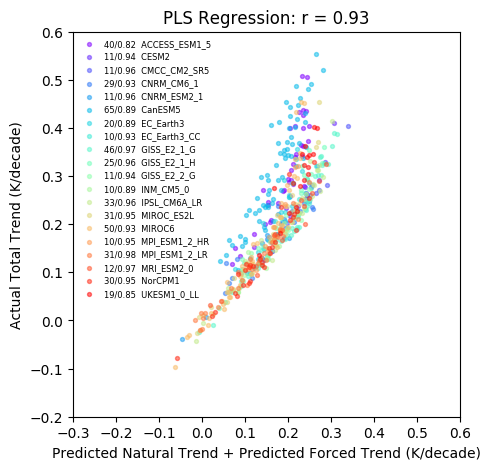

In [19]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = TestingTotalTrend[model_idx]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        #val = ValidationData[:,predictant_idx]
        val = ValidationData
        pred = PredictedData[:,0] + PredictedData[:,3]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(pred, ValidationData, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-.2,.6)
        axs_obj.set_xlim(-.3,.6)
        axs_obj.set_ylabel('Actual Total Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural Trend + Predicted Forced Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('PLS Regression: r = ' + str(np.nanmean(all_r_values))[:4])


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


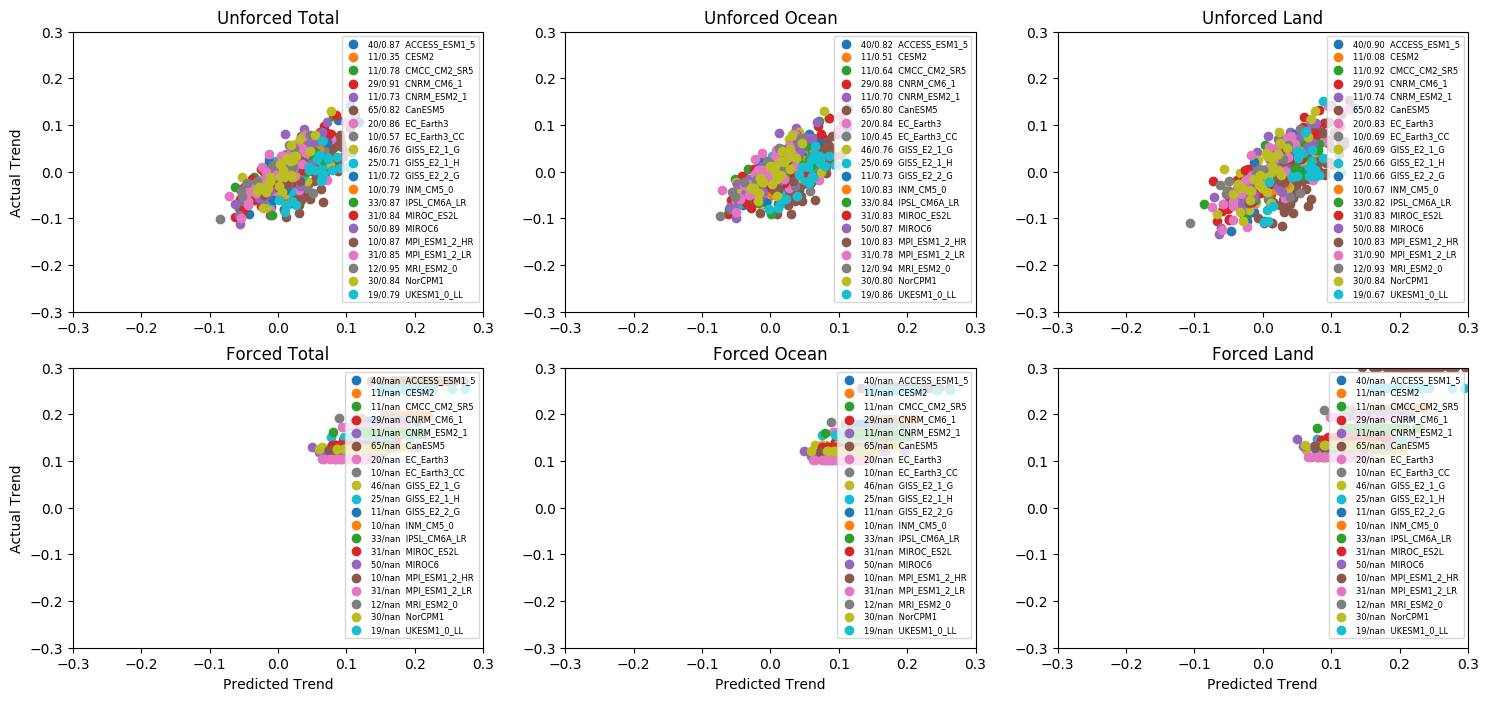

In [15]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

# the second axis in ValidationData and PredictedData is stored as follows
titles = ['Unforced Total', 'Unforced Ocean', 'Unforced Land', 'Forced Total', 'Forced Ocean', 'Forced Land']

all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)

    r_values = []
    for predictant_idx in range(6):
        val = ValidationData[:,predictant_idx]
        pred = PredictedData[:,predictant_idx]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        axs_obj = axs.flatten()[predictant_idx]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData[:,predictant_idx], label=label_id)
        axs_obj.legend(loc=1, prop={'size': 6})
        axs_obj.set_ylim(-.3,.3)
        axs_obj.set_xlim(-.3,.3)
        axs_obj.set_title(titles[predictant_idx])
        if (predictant_idx == 0) or (predictant_idx == 3):
            axs_obj.set_ylabel('Actual Trend')
        if (predictant_idx >=3):
            axs_obj.set_xlabel('Predicted Trend')
    all_r_values.append(r_values)
